# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [4]:
import numpy as np
import pandas as pd
from sklearn import tree

input_file = "C:\MLCourse\MLCourse\FinalProject\mammographic_masses.data.txt"

df = pd.read_csv(input_file)
df.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [5]:
df = pd.read_csv(input_file, na_values=['?'], names=['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity'])
df.head(10)

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,NaN,5.0,1.0,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [6]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [7]:
df.loc[(df['age'].isnull()) |
       (df['shape'].isnull()) |
       (df['margin'].isnull()) |
       (df['density'].isnull())]

,BI_RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [8]:
df.dropna(inplace=True)
df.head(10)


,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1
11,3.0,42.0,2.0,1.0,3.0,1
13,4.0,36.0,3.0,1.0,2.0,0
14,4.0,60.0,2.0,1.0,2.0,0
15,4.0,54.0,1.0,1.0,3.0,0
16,3.0,52.0,3.0,4.0,3.0,0


In [9]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [10]:
feature_data = df[['age', 'shape', 'margin', 'density']]

class_data = df[['severity']]

feature_data = feature_data.to_numpy()
class_data = class_data.to_numpy()

feature_data

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [11]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler()
feature_data_scaled = scaler.fit_transform(feature_data)

feature_data_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [12]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_classes, test_classes = train_test_split(feature_data_scaled, class_data, test_size=0.25)

train_features.size
test_features.size
train_classes.size
test_classes.size

208

In [13]:
print(train_features.size)
print(test_features.size)
print(train_classes.size)
print(test_classes.size)

2488
832
622
208


Now create a DecisionTreeClassifier and fit it to your training data.

In [14]:
from sklearn.tree import DecisionTreeClassifier

#Create Decision Tree Classifier Object
clf = DecisionTreeClassifier()

#Train Decision Tree Classifier 
clf = clf.fit(train_features, train_classes, 
              epochs=100)

Display the resulting decision tree.

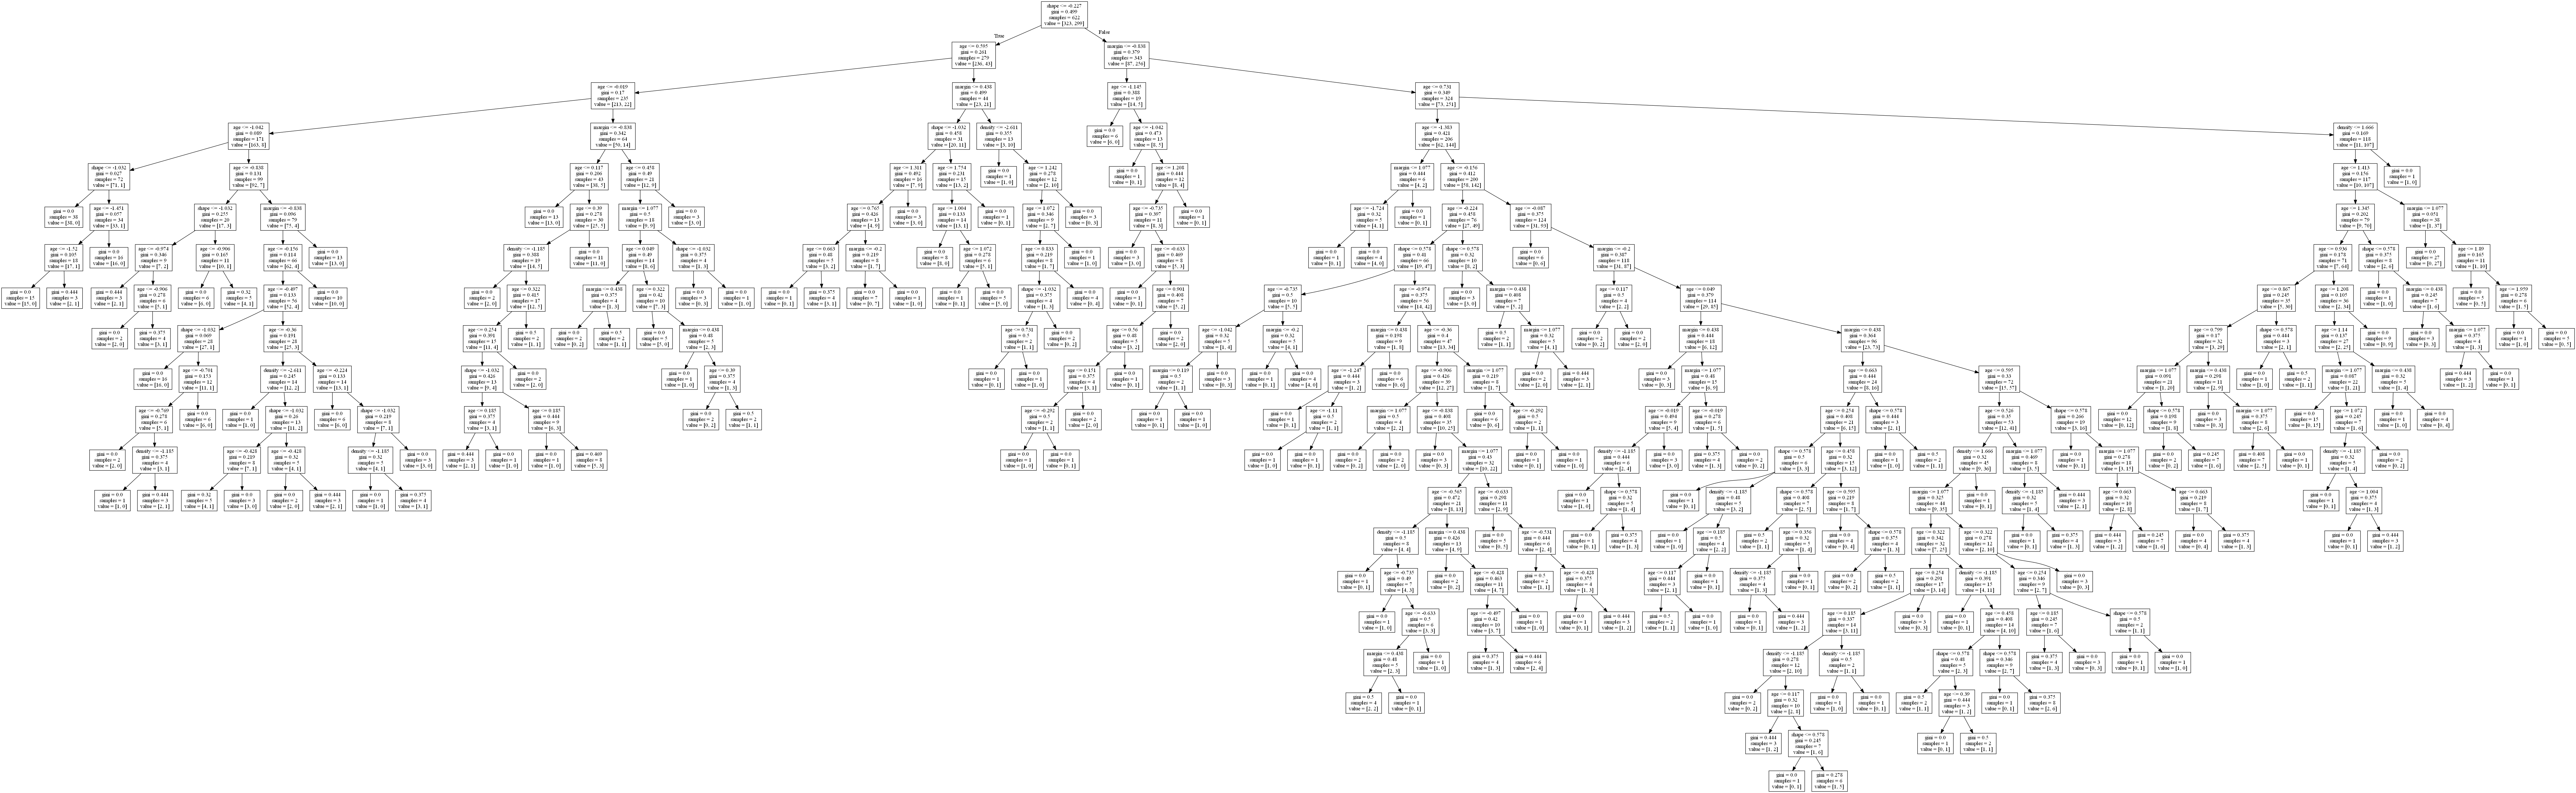

In [15]:
from IPython.display import Image  
from six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

feature_names = ['age', 'shape', 'margin', 'density']
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names)  

graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Measure the accuracy of the resulting decision tree model using your test data.

In [16]:
clf.score(test_features, test_classes)

0.7163461538461539

In [17]:
#Predict response 
pred = clf.predict(test_features)

In [18]:
#Model Accuracy
from sklearn import metrics 

acc = metrics.accuracy_score(test_classes, pred)

print("Accuracy: ", acc)


Accuracy:  0.7163461538461539


Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [19]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, feature_data_scaled, class_data, cv=10)

print(scores)

[0.73493976 0.78313253 0.73493976 0.74698795 0.78313253 0.69879518
 0.73493976 0.74698795 0.74698795 0.68674699]


In [20]:
print(scores.mean())

0.7397590361445783


Now try a RandomForestClassifier instead. Does it perform better?

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
rf_scores = cross_val_score(clf, feature_data_scaled, class_data, cv=10)

print(rf_scores)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[0.74698795 0.72289157 0.77108434 0.75903614 0.78313253 0.72289157
 0.78313253 0.77108434 0.79518072 0.6746988 ]


C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [22]:
print(rf_scores.mean())
##yes

0.753012048192771


## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [23]:
from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=C)

In [24]:

svm_scores = cross_val_score(svc, feature_data_scaled, class_data, cv=10)
print(svm_scores)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda\lib\

[0.71084337 0.79518072 0.84337349 0.80722892 0.84337349 0.72289157
 0.79518072 0.81927711 0.87951807 0.75903614]


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [25]:
print(svm_scores.mean())
#it performs better than decision tree

0.7975903614457832


## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [26]:
from sklearn.neighbors import KNeighborsClassifier

cvf = KNeighborsClassifier(n_neighbors=10)

knn_scores = cross_val_score(cvf, feature_data_scaled, class_data, cv=10)

print(knn_scores)
print(knn_scores.mean())

[0.75903614 0.78313253 0.80722892 0.75903614 0.87951807 0.74698795
 0.84337349 0.79518072 0.8313253  0.71084337]
0.7915662650602409


C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fi

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [29]:
class_data = df['severity'].values

for k in range(1, 50):
    cvf = KNeighborsClassifier(n_neighbors=k)
    knn_scores = cross_val_score(cvf, feature_data_scaled, class_data, cv=10)
    print(knn_scores.mean())
    
#best is k = 7

0.7325301204819278
0.6903614457831325
0.7542168674698796
0.7349397590361446
0.7710843373493976
0.7686746987951807
0.7951807228915662
0.7771084337349398
0.7903614457831326
0.7915662650602409
0.7891566265060241
0.783132530120482
0.7879518072289157
0.7867469879518072
0.7867469879518072
0.7831325301204819
0.7783132530120482
0.7783132530120482
0.7843373493975904
0.7855421686746988
0.7879518072289156
0.7855421686746988
0.7783132530120481
0.7783132530120482
0.7867469879518072
0.7855421686746988
0.7855421686746988
0.7867469879518072
0.7855421686746988
0.7903614457831325
0.7867469879518072
0.789156626506024
0.7879518072289156
0.7867469879518072
0.7831325301204819
0.7867469879518072
0.7843373493975904
0.7867469879518072
0.7819277108433734
0.7843373493975904
0.780722891566265
0.7819277108433734
0.780722891566265
0.7819277108433734
0.7831325301204819
0.7843373493975904
0.789156626506024
0.7903614457831325
0.7915662650602409


## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [33]:
from sklearn.naive_bayes import MultinomialNB

feature_data = df[['age', 'shape', 'margin', 'density']].values

scaler = preprocessing.MinMaxScaler()
feature_data_minmax = scaler.fit_transform(feature_data)

cvf = MultinomialNB()

nb_scores = cross_val_score(cvf, feature_data_minmax, class_data, cv=10)

print(nb_scores)
print(nb_scores.mean())

##not as good as knn

[0.73493976 0.78313253 0.79518072 0.8313253  0.8313253  0.78313253
 0.74698795 0.75903614 0.89156627 0.69879518]
0.7855421686746988


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [34]:
C = 1.0
svc = svm.SVC(kernel='rbf', C=C)

svm_scores = cross_val_score(svc, feature_data_scaled, class_data, cv=10)

print(svm_scores)
print(svm_scores.mean())

[0.75903614 0.81927711 0.84337349 0.81927711 0.85542169 0.74698795
 0.75903614 0.78313253 0.85542169 0.77108434]
0.8012048192771084


In [35]:
svc = svm.SVC(kernel='sigmoid', C=C)

svm_scores = cross_val_score(svc, feature_data_scaled, class_data, cv=10)

print(svm_scores)
print(svm_scores.mean())

[0.68674699 0.69879518 0.77108434 0.74698795 0.73493976 0.72289157
 0.80722892 0.78313253 0.71084337 0.79518072]
0.7457831325301204


In [36]:
svc = svm.SVC(kernel='poly', C=C)

svm_scores = cross_val_score(svc, feature_data_scaled, class_data, cv=10)

print(svm_scores)
print(svm_scores.mean())

[0.75903614 0.79518072 0.84337349 0.80722892 0.8313253  0.73493976
 0.74698795 0.79518072 0.84337349 0.74698795]
0.7903614457831326


## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

In [ ]:
#Support Vector Machine with the rbf hyperparameter is the best with 80% accuracy


SVM-rbf: 0.801
SVM-linear: 0.798
KNN-7: 0.795
KNN-10: 0.792
SVM-poly: 0.790
Naive-Bayes: 0.786
Random Forrest: 0.750
SVC-sigmoid: 0.746
Decision Tree: 0.730


